In [1]:
import os

import numpy as np
import tensorflow as tf

In [2]:
def load_data(path):
    x = None
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'rb') as f:
            tmp = tf.cast([np.load(f)], dtype=tf.float64)
            if x is None:
                x = tf.linalg.matmul(tmp, tmp, transpose_b=True)
            else:
                x = tf.concat([x, tf.linalg.matmul(tmp, tmp, transpose_b=True)], axis=0)
    return x

In [3]:
def fusion(x, k, steps, alpha, beta, gamma):
    n = x.shape[1]
    t = x.shape[0]
    reg = gamma / (4.0 * beta)
    wv, wv_u = tf.cast([1.0 / t for _ in range(t)], dtype=tf.float64), None
    i_alpha = tf.math.multiply(tf.eye(n, dtype=tf.float64), alpha)
    i_beta = tf.math.multiply(tf.eye(n, dtype=tf.float64), beta)
    s = tf.eye(n, dtype=tf.float64)
    for step in range(steps):
        s = tf.where(s > 0, s, tf.zeros(s.shape, dtype=tf.float64))
        s = tf.math.divide(tf.math.add(s, tf.transpose(s)), 2.0)
        z_sum = tf.zeros(s.shape, dtype=tf.float64)
        for i in range(t):
            z = tf.linalg.solve(
                tf.math.add(tf.math.add(x[i], i_alpha), tf.math.multiply(i_beta, wv[i])),
                tf.math.add(tf.math.multiply(s, tf.math.multiply(wv[i], beta)), x[i]))
            z = tf.where(z > 0, z, tf.zeros(z.shape, dtype=tf.float64))
            z = tf.math.divide(tf.math.add(z, tf.transpose(z)), 2.0)
            w = tf.math.divide(0.5, tf.norm(tf.math.subtract(z, s)))
            wv_u = tf.reshape(w, [1]) if i == 0 else tf.concat([wv_u, [w]], axis=0)
            z = tf.math.multiply(z, w)
            z_sum = tf.math.add(z_sum, z)
        (_, f) = tf.linalg.eigh(tf.math.subtract(tf.linalg.diag(tf.math.reduce_sum(s, 0)), s))
        f = tf.slice(f, [0, 0], [f.shape[0], k])
        p = tf.norm(tf.math.subtract(f[0][:], f), axis=1, keepdims=True)
        for i in range(1, n):
             p = tf.concat([p, tf.norm(tf.math.subtract(f[i][:], f), axis=1, keepdims=True)], 1)
        p = tf.math.multiply(tf.math.square(p), reg)
        wv = wv_u
        s_old = s
        s = tf.math.divide((tf.math.subtract(z_sum, p)), tf.math.reduce_sum(wv, 0))
        if step >= 4 and tf.math.less(tf.math.divide(tf.norm(tf.math.subtract(s, s_old)), tf.norm(s_old)), 1.e-3):
            return s.numpy()
    return s.numpy()

In [4]:
from sklearn.cluster import SpectralClustering

def run_clustering(k, x):
    labels = SpectralClustering(n_clusters=k, affinity='precomputed', assign_labels='discretize').fit(x).labels_
    d = {}
    for i in labels:
        if i in d:
            d[i] += 1
        else:
            d[i] = 1
    big, small = float('-inf'), float('inf')
    for i in d:
        big = max(big, d[i])
        small = min(small, d[i])
    return labels, big, small, d

In [5]:
def run_experiments(ks, views):
    x = load_data(views)
    print(x.shape)
    steps, alphas, betas, gammas = 20, [0.1, 1.0], [1000.0, 4000.0, 100.0], [0.01, 0.1]
    # steps, alphas, betas, gammas = 20, [0.1], [4000.0], [0.01]
    biggest, smallest = {}, {}
    for k in ks:
        for alpha in alphas:
            for beta in betas:
                for gamma in gammas:
                    s = fusion(x, k, steps, alpha, beta, gamma)
                    (labels, big, small, d) = run_clustering(k, s)
                    is_better = False
                    if k in biggest:
                        if big < biggest[k] or (big == biggest[k] and small > smallest[k]):
                            is_better = True
                    else:
                        is_better = True
                    if is_better:
                        biggest[k] = big
                        smallest[k] = small
                        histograms[k] = [d, 'k: ' + str(k) + ', Biggest: ' + str(big) + ', Smallest: ' + str(small) +
                                         ', params: ' + ' '.join([str(alpha), str(beta), str(gamma)])]

In [6]:
def save_np(folder, name, matrix):
    os.makedirs(folder, exist_ok=True)
    with open(os.path.join(folder, name) + ".npy", 'wb') as f:
        np.save(f, matrix)

In [7]:
def run(views):
    x = load_data(views)
    print(x.shape)
    steps, alpha, beta, gamma = 20, 0.1, 4000.0, 0.01
    k = int(x.shape[1] / 10)
    s = fusion(x, k, steps, alpha, beta, gamma)
    return k, s

def run_by_levels(views, results):
    for level in next(os.walk(views))[1]:
        (k, s) = run(os.path.join(views, level))
        (labels, big, small, d) = run_clustering(k, s)
        histograms[level] = [d, level + ', n: ' + str(s.shape[0]) + ', k: ' + str(k)
                             + ', Biggest: ' + str(big) + ', Smallest: ' + str(small)]
        save_np(os.path.join(results, level), 'labels', labels)


In [11]:
histograms = {}
run_by_levels('views/profiles/', 'clusters/profiles/')
# run_experiments([4, 7, 9, 12], 'views/profiles/level_1/')

(3, 237, 237)
(3, 948, 948)
(3, 51, 51)


In [9]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

def plot_histograms():
    plt.figure(figsize=(18, 24))
    plt.subplots_adjust(hspace=0.4)
    cnt = 1
    for h in histograms:
        plt.subplot(len(histograms), 2, cnt)
        cnt += 1
        d = histograms[h][0]
        plt.bar(d.keys(), d.values())
        plt.title(histograms[h][1])

spectral clustering precomputed discretize


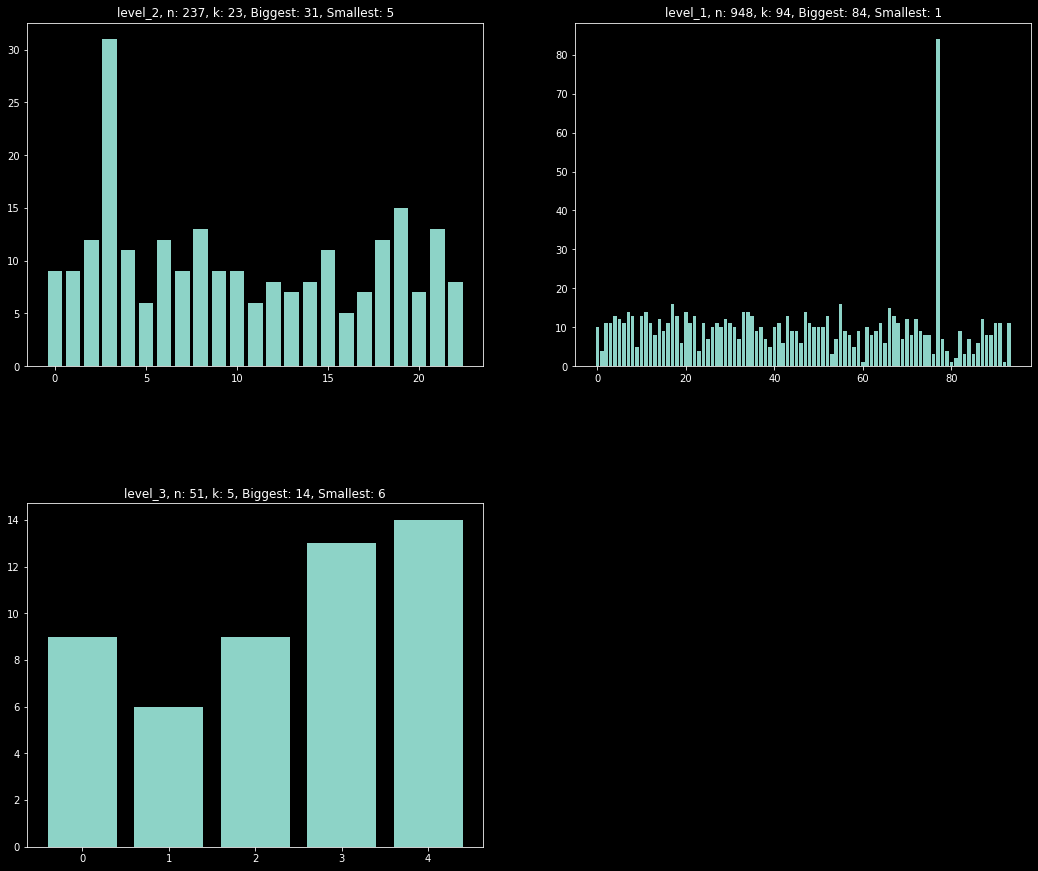

In [12]:
print("spectral clustering precomputed discretize")
plot_histograms()